![Titlepic](Images/machine_setup.png)

# Introduction


This paper describes how to derive the kinematic model for a 5-axis machine tool in an XYZBC configuration with Tool side B nutating rotation of the spindle and work side C (table) rotation. The model presented here will be named 'XYBC-SNTR'.

The method used here will be a step by step approach. Starting with a working kinematic model for a single rotary axis all the required elements will be added to build a complete kinematic model for the machine.

The final model includes tool-length compensation, compensation for spindle pivot length and compensation for setups where the machine reference point is not located on the rotation-axis of the rotary table. The nutation angle is adjustable from 0 to 90° as measured from the vertical.  

In this document only basic mathematical functions are used so the kinematic models derived can be used directly in the 'userkins.comp' template file provided with the LinuxCNC installation. All calculations can be done whithout the use of any computer algebra systems, however the use of computer assistance like 'sage' will make the process of matrix multiplication much less error prone.

Note that there are other and potentially more computationally efficient ways to build custom kinematics using built in libraries like 'posemath'. Posemath provides many functions for efficient matrix manipulation and also offers functions for the use of quaternions. However the use of such a library would require a more indepth understanding of the mathematical theory that is beyond the scope of this presentation. Furthermore importing a library like 'posemath' into the 'userkins.comp' template would require substantially more programming skills than using the method applied in this paper. 

In [1]:
from IPython.display import display, Image
# only used to display equations out of code blocks
from IPython.display import Math, display

# joint position vector P 
var('Px','Py','Pz')
P_=matrix([[Px],
           [Py],
           [Pz],
           [1]])

# cartesian position vector Q
var('Qx','Qy','Qz')
Q_=matrix([[Qx],
           [Qy],
           [Qz],
           [1]])

A custom kinematic model in LinuxCNC is used to calculate cartesian coordinates from given machine joint positions (forward kinematics) and also to calculate the required machine joint positions to reach a given coordinate position (inverse kinematics). In the following description we will use vectors as mathematical representations of the two positions: 


\begin{equation}
Q ~=~
\left(\begin{array}{rrrr}
  Qx \\
  Qy \\
  Qz \\
  1
\end{array}\right)
~
Cartesian~position
~~~~~~~~~~~~
P ~=~
\left(\begin{array}{rrrr}
  Px \\
  Py \\
  Pz \\
  1
\end{array}\right)
~
Joint~position
\end{equation}

Note that the fourth row is added to be able to multiply the vectors with a 4x4 transformation matrix. 

# TCP Kinematic model
For the tool to follow a point on the work piece we need a model that calculates where a given position on the work piece moves to when the rotary joints are rotated. In our example configuration the work piece will be mounted on therotary table and it is therefore here where we start to build our forward kinematic model.<br>
Note that in matrix multiplication the order is important, that is, $A\cdot B$ is generally not equal to $B \cdot A$. 





## Table Rotary
### Forward transformation

We start with the work side rotation. In this case our forward transformation matrix $^QA_P$ is equal to a rotation around the X-axis:

\begin{equation}
 ^QA_P=~ R_w 
\end{equation}



In [2]:
#define rotation matrix for work side rotation (ie the rotary table)
var('Cw','Sw')
Rw=matrix([[ Cw, -Sw, 0, 0],
           [ Sw,  Cw, 0, 0],
           [ 0,   0,  1, 0],
           [ 0,   0,  0, 1]])

display(Math(rf'R_w =~'+latex(Rw)))

<IPython.core.display.Math object>

with $~~Sw = sin(\theta_w),~~~ Cw = cos(\theta_w)$
and $\theta_w$ being the angle of rotation of the table rotary

To derive the coordinate position $Q(Qx,Qy,Qz)$ we now need to multiply the joint position vector $P(Px,Py,Pz)$ with our forward transformation matrix $^QA_P$. <br>
Note that the input values $P$ to our model need to be on the right hand side of the matrix multiplication.

$$ Q=~^QA_P \cdot P $$

In [3]:
# calculate forward kinematic
Q_out=Rw*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Rw)+rf'\cdot'+latex(P_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

---

### Inverse transformation

To calculate the joint position $P$ from given coordinate positions $Q$ we need to 'unrotate' the rotary table. Mathematically this means we need to transpose the rotation part in our transformation matrix.

\begin{equation}
 ^PA_Q=~ R_w^T 
\end{equation}

To derive the joint position $P$ we then multiply the coordinate position vector $Q$ from the right:

\begin{equation}
 P=~^PA_Q \cdot Q
\end{equation}

In [4]:
# calculate inverse kinematic
P_out=Rw.transpose()*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(Rw.transpose())+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [5]:
# define joint position matrix
var('Px','Py','Pz')
Tp=matrix([[ 1, 0, 0, Px ],
           [ 0, 1, 0, Py],
           [ 0, 0, 1, Pz],
           [ 0, 0, 0, 1 ]])


In [6]:
# calculate the forward transformation matrix
qAp=Rw*Tp
display(Math(rf'^QA_P =~~'+latex(Rw)+rf'\cdot'+latex(Tp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## A closer look at the spindle rotary assembly

To get a better understanding of these offsets in the spindle rotary assembly of our example machine we need to have a look at how the primary rotary axis and the secondary rotary axis are arranged in the spindle body. <br>
The image below shows our spindle assembly in its home position ($\theta_p =0$, $\theta_s=0$). To get a clearer idea of the situation a tool (purple cylinder) is shown protruding from the spindle nose.


## Pivot-point and pivot-length of the spindle head
Because the rotation axes and offsets in question are all hidden inside the spindle body we simplify the model to the relevant kinematic components. The white cross with the arrow pointing up shows the intersection of the rotary axes (yellow sphere).
This point will be refered to as the 'pivot-point' of the spindle rotary assembly.
The primary rotary axis (yellow line) extends vertically from the pivot-point in the machine-z direction.
The secondary rotary axis (yellow line) extends from the pivot-point towards the rotational axis of the tool (purple cylinder) attaches. Note here that this axis will only intersect with the center of the spindle nose it the nutation angle happens to be 45°. <br>
The 'y-pivot-length' is the distance in the y-direction between the pivot-point and the spindle nose and shown in green.
The 'z-pivot-length' is the distance in the z-direction between the pivot-point and the spindle nose and shown in blue.
Note that in this image there is no geometric offset between the two rotary axes and they intersect at the pivot-point. 
<br>
We define the values for the offsets in the example image as *y-pivot = 50* and *z-pivot = 200*. In our kinematic model this represents the situation where, starting from the spindle nose, we need to travel 200 in the positive z-direction and 50 in the positive y-direction to reach the pivot-point.
<br>
Note that the direction of travel when defining these offsets is arbitrary so in our case the offset situation in the image could also be defined as -50 in y and -200 in z. However once the definition is made we must keep it throughout the entire process of building the kinematic model.

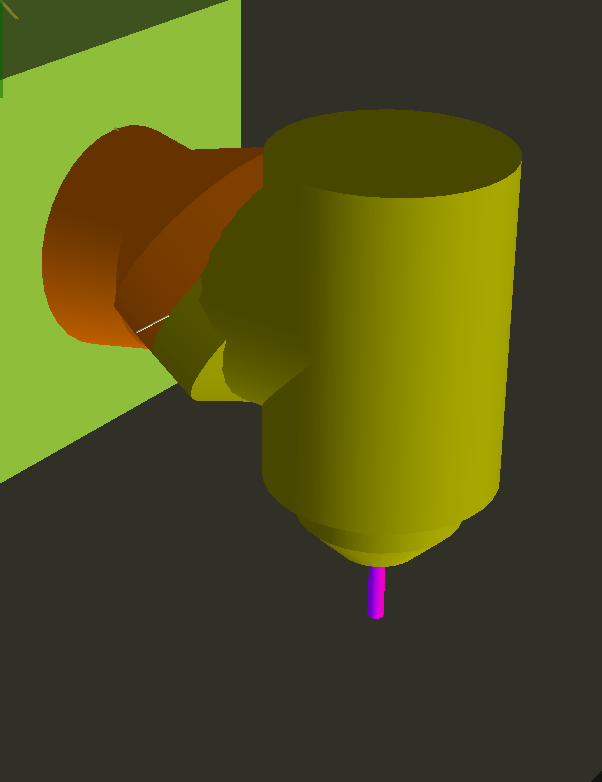

In [7]:
display(Image(filename="Images/spindle_head_outside.png",
              height=300, width=300))

To be able to add these (y,z)-pivot values to our kinematic model we need to create a transformation matrix that has the effect of a translation. 
Note that the direction chosen for these offsets is important here as our translation is basically a vector and we have chosen that this 'pivot-length' vector points from the spindle nose to the pivot-point. Since we are building the forward kinematic model we are travelling against this vector and thus its components ($L_y,L_z$) need to be entered in the negative.

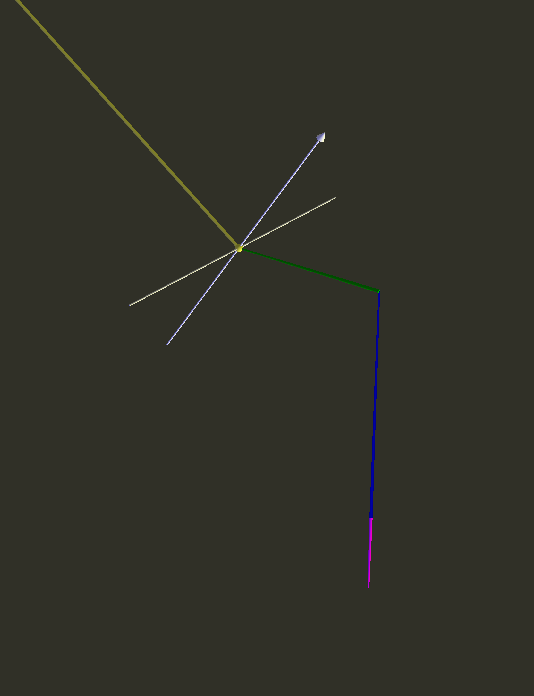

In [8]:
display(Image(filename="Images/spindle_head_inside.png",
              height=300, width=300))

In [9]:
# define translation matrix for the pivot lengths
var('Ly','Lz')
Tl=matrix([[ 1, 0, 0, 0 ],
           [ 0, 1, 0, -Ly],
           [ 0, 0, 1, -Lz],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_l =~'+latex(Tl)))

<IPython.core.display.Math object>

In this machine configuration we have no further geometrical offsets.

In [10]:
# define translation matrix for the offsets
# no offsets so we use the identity matrix 
Td=matrix([[ 1, 0, 0, 0],
           [ 0, 1, 0, 0],
           [ 0, 0, 1, 0],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_d =~'+latex(Td)))

<IPython.core.display.Math object>


## Spindle Rotary
### How to derive a rotation matrix for a nutating joint

The machine in our example has a 'nutating' secondary rotary joint. Nutating meaning here that the rotational axis is not parallel to any of the axes (x, y or z) of our machine coordinate system and hence we cannot use any of the basic rotation matrices to model it in our kinematic. The basic rotation matrices are only three particular solutions of a general formula to describe rotations around any given vector $V(v_x, v_y, v_z$) in space.
In our particular case we will see that a regular (ie orthogonal) rotary assembly corresponds to a nutation angle of 90° and our kinematic model will also cover this particular machine type.<br>
To construct the rotation matrix $R_s$ for the slanted sencondary joint of our spindle we will use the ‘Rodrigues' form of the general rotation formula. (Note that there is also an 'Euler-Rodrigues' formula that can be used for the same purpose but uses different parameters.)

\begin{equation}
R_s ~=~ I ~+~ sin\theta \cdot V + (2sin²{\theta \over2}) \cdot V²
\label{eq:rod_rot}
\end{equation}
where $\theta$ is the angle of positive rotation around a vector $\vec{v}$ acording to the 'Right-Hand' rule.

With:
\begin{equation}
I ~=~ 
\left(\begin{array}{rrrr}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{array}\right)
~~
V ~=~
\left(\begin{array}{rrrr}
  0  & -v_z &  v_y \\
 v_z &   0  & -v_x  \\
-v_y &  v_x  &   0 
\end{array}\right)
\label{eq:mat_I_V}
\end{equation}

For the matrix $V$ we need a unit vector that represents the rotational axis of the nutating joint:

$$\vec{v}=(v_x,v_y,v_z)$$

In our case the nutating axis lies in the YZ-plane and has the components:

$$v_x=0, ~~~~ v_y = sin\nu, ~~~~ v_z = cos\nu$$ 

where $\nu$ is the angle of the nutating axis as measured from the vertical.


Using the definitions of $I$ and $V$ we can rewrite  $R_s $ as:

\begin{equation}
R_s ~=~
\left(\begin{array}{rrrr}
  cos\theta+v²_x(1-cos\theta)   &   v_x v_y(1-cos\theta)-v_z sin\theta  &  v_x v_z(1-cos\theta)+v_y sin\theta \\
  v_x v_y(1-cos\theta)+v_z sin\theta  &   cos\theta+v²_y(1-cos\theta)   &  v_y v_z(1-cos\theta)-v_x sin\theta \\
  v_x v_z(1-cos\theta)-v_y sin\theta  &   v_y v_z(1-cos\theta)+v_x sin\theta   &   cos\theta+v²_z(1-cos\theta) 
\end{array}\right)
\end{equation}


For simplicity we substitute 
$$sin\nu = Sv, ~~~~ cos\nu = Cv, ~~~~ sin\theta = Ss, ~~~ cos\theta = Cs$$

using the components of $\vec{v}$ the rotation matrix of our secondary joint now becomes

\begin{equation}
R_s ~=~
\left(\begin{array}{rrrr}
   Cs   &           -CvSs        &        SvSs       \\
  CvSs  &      Cs + S²v(1-Cs)    &     SvCv(1-Cs)    \\
 -SvSs  &        SvCv(1-Cs)      &   Cs + C²v(1-Cs) 
\end{array}\right)
\end{equation}

and by expanding it to a 4x4 matrix we have now the required transformation matrix

\begin{equation}
R_s ~=~
\left(\begin{array}{rrrr}
   Cs   &           -CvSs        &        SvSs        &      0     \\
  CvSs  &      Cs + S²v(1-Cs)    &     SvCv(1-Cs)     &      0     \\
 -SvSs  &        SvCv(1-Cs)      &   Cs + C²v(1-Cs)   &      0     \\
   0    &             0          &         0          &      1
\end{array}\right)
\end{equation}


To make the matrix multiplications more manageable we substitute 


$$ Cs + S²v(1-Cs)~=~ r   ~~~~~~~~  Cs + C²v(1-Cs) ~=~ s ~~~~~~~~  SvCv(1-Cs) ~=~ t  $$ 

and get the transformation matrix in it's final form

\begin{equation}
R_s ~=~
\left(\begin{array}{rrrr}
   Cs   &  -CvSs  &   SvSs  &  0     \\
  CvSs  &    r    &    t    &  0     \\
 -SvSs  &    t    &    s    &  0     \\
   0    &    0    &    0    &  1
\end{array}\right)
\end{equation}

In [11]:
# define rotation matrix for the secondary spindle joint
var('Cs','CvSs','SvSs','r','s','t')
Rs=matrix([[ Cs  , -CvSs,  SvSs, 0],
           [ CvSs,     r,     t, 0],
           [-SvSs,     t,     s, 0],
           [    0,     0,     0, 1]])

## Tool length offset (TLO)

As we could see above in our inspection of the spindle rotary assembly the tool length offset ($Dt$) has the same direction as the z-component of the pivot-offset ($Lz$) that is, a positive $Dt$ value points in the negative machine-z direction.
So as a building block in our forward kinematic transformation the value of $Dt$ needs to be in the negative:

In [12]:
# define translation matrix for the tool length
var('Dt')
Tt=matrix([[ 1, 0, 0,  0],
           [ 0, 1, 0,  0 ],
           [ 0, 0, 1, -Dt],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_t =~'+latex(Tt)))

<IPython.core.display.Math object>

In [13]:
Tz=Tl*Tt
display(Math(rf'T_lt =~'+latex(Tl)+rf'\cdot'+latex(Tt)+rf'=~'+latex(Tz)))

<IPython.core.display.Math object>


## Table and Spindle rotations with offsets
Now that we have all the building blocks we can put everything together:

$$ ^QA_P = R_w \cdot T_p \cdot T_d \cdot R_s \cdot T_l \cdot T_t$$

In [14]:
# calculate the forward transformation matrix
# note: the brackets *(Tl*Tt) are only used to get a cosmetically
# prettier result since it seems to keep "(Dt+Lz)"
qAp=Rw*Tp*Td*Rs*(Tl*Tt)
display(Math(rf'^Q A_P =~'+latex(qAp)))


<IPython.core.display.Math object>

In [15]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
Qx=qAp[0][3]
Qy=qAp[1][3]
Qz=qAp[2][3]

display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

So with this as our core forward transformation matrix we can now check the output of this model for a nutation angle $\nu = 45°$ with the spindle assembly in the home position:

$$P(Px,Py,Pz)=(0,0,0)$$

$$\theta_w = \theta_p = \theta_s =0 ~~=>~~ (Cw=Cp=Cs=1, ~~Sw=Sp=Ss=0)$$

taking our substitution in $R_s$ into account:

$$  Cs + S²\nu(1-Cs)~=~ r   ~~~~~~~~  Cs + C²\nu(1-Cs) ~=~ s  ~~~~~~~~  S\nu C\nu(1-Cs) ~=~ t$$ 

for our chosen nutation angle of $\nu = 45°$ this becomes

$$ Cs~=~ r   ~~~~~~~~  Cs~=~ s  ~~~~~~~~   S_{\nu} ~=~ t $$
~
which for $\theta_a = 0$ reduces to:

$$  r=~ 1   ~~~~~~~~  s~=~ 1  ~~~~~~~~  t~=~ 0 $$ 


Thus we get the coordinates:
$$Qx= 0 $$
$$Qy= -Ly) $$
$$Qz= -(Dt + Lz) $$

\begin{equation}
Q ~=~
\left(\begin{array}{r}
  Qx \\
  Qy \\
  Qz \\
  1
\end{array}\right)
~=~
\left(\begin{array}{r}
  0 \\
  -Ly \\
  -Dt-Lz \\
  1
\end{array}\right)
\end{equation}

Since we started out with all joints in the home position we would expect the resulting coordinate position to be $Q(Qx,Qy,Qz)=(0,0,0)$. Hence we need to compensate for the offsets in our resulting coordinate position by subtracting them from the result of our core transformation matrix. 
Note subtracting a vector is the same as adding its inverse vector 
We define the transformation:


In [16]:
Tc=matrix([[ 1, 0, 0,   0 ],
           [ 0, 1, 0,   Ly],
           [ 0, 0, 1, (Dt+Lz)],
           [ 0, 0, 0,   1 ]])
display(Math(rf'T_c =~'+latex(Tc)))

<IPython.core.display.Math object>

Note that this is a translation of the result of our forward transformation matrix $^QA_P$ it needs to be multiplied from the left:

$$^QA_P = T_c \cdot R_w \cdot T_p \cdot T_d \cdot R_s \cdot T_l \cdot T_t$$

In [17]:
# calculate the forward transformation matrix
# note: the brackets *(Tl*Tt) are only used to get a cosmetically
# prettier result since it seems to keep "(Dt+Lz)"
qAp=Tc*Rw*Tp*Td*Rs*(Tl*Tt)
display(Math(rf'^Q A_P =~'+latex(qAp)))

<IPython.core.display.Math object>

In [18]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
Qx=qAp[0][3]
Qy=qAp[1][3]
Qz=qAp[2][3]

display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---

## Position offset of the rotary table to the machine reference point
 
Up to this point we have assumed that the machine reference point coincides with the rotational axis of our rotary table.
However, it is somewhat unlikely that a machines home position is exactly in the rotational axis of the rotary table and this will need to be taken into account in the kinematic model.<br>
Let us assume that we have a setup with no TLO ($Dt=0$), no geometric offset ($Dx=Dy=0$), no pivot-length ($Ly=Lz=0$) and no offset of the rotation-axis of the rotary table to the machine reference point.<br>
A tool positioned on the rotational axis of the rotary table would have a joint-position of $P(0,0,P_z)$ and that would give the expected resulting coordinate position of $Q(0,0,P_z)$.<br>
If we now assume that the rotation-axis of our rotary table is offset from the machine reference point by $(ra_y,ra_z)$ then our joint-position would be equal to $P(0,ra_y,ra_z)$ which would give us a result of $Q(0,ra_y, ra_z)$.<br>
So we need to subtract the offset $(ra_y,ra_z)$ from the joint-position $P=(P_x, P_y-ra_y, P_z-ra_z)$ before we input it into our transformation matrix.  In other words we need to translate the joint-position vector in the opposite direction along the offset vector with the components $(0,ra_y,ra_z)$. 

In [19]:
var('Drax','Dray','Draz')
# define offset translation matrix for the rotary c table
Tr=matrix([[ 1, 0, 0, -Drax],
           [ 0, 1, 0, -Dray],
           [ 0, 0, 1,     0],
           [ 0, 0, 0,     1]])
display(Math(rf'Tr =~'+latex(Tr)))



<IPython.core.display.Math object>

Note that this is a translation $T_r$ of the input $T_p$ of our forward transformation matrix $^QA_P$ so it needs to be multiplied to $T_p$ from the right :

In [20]:
Tpr=Tp*Tr
display(Math(rf'T_p \cdot T_r =~'+latex(Tp)+rf'\cdot'+latex(Tr)+rf'=~'+latex(Tpr)))

<IPython.core.display.Math object>

Thus we get:

$$^QA_P = T_c \cdot R_w \cdot T_p \cdot T_r \cdot R_p \cdot T_d \cdot R_s \cdot T_l \cdot T_t$$



However some more consideration is needed for now a joint position of $P(0,ra_y,ra_z)$ will result in a coordinate position of $Q(0,0,0)$ which is of course not the value we can hand back to LinuxCNC because if the rotation axis is offset from machine home position then the coordinate position would need to be $Q(0,ra_y,ra_z)$.<br> 
So to be consistent we need to add the offset values back to the results of our calculations which we do again by multiplying a vector translation to the left of our forward kinematic:

In [21]:
Tnr=matrix([[ 1, 0, 0, Drax],
            [ 0, 1, 0, Dray],
            [ 0, 0, 1,    0],
            [ 0, 0, 0,    1]])
display(Math(rf'T._r =~'+latex(Tnr)))

<IPython.core.display.Math object>

Thus we get our final forward transformation matrix:

$$^QA_P = T_{-r} \cdot T_c \cdot R_w \cdot T_p \cdot T_r \cdot R_p \cdot T_d \cdot R_s \cdot T_l \cdot T_t$$



In [23]:
# calculate the forward transformation matrix
# note: the brackets *(Tl*Tt) are only used to get a cosmetically
# prettier result since it seems to keep "(Dt+Lz)"
# similar for (Tp*Tr)
qAp=Tnr*Tc*Rw*(Tp*Tr)*Td*Rs*(Tl*Tt)
display(Math(rf'^Q A_P =~'+latex(qAp)))

<IPython.core.display.Math object>

In [24]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
Qx=qAp[0][3]
Qy=qAp[1][3]
Qz=qAp[2][3]

display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
# expressions as used in kinematics component
print('TCP kinematics FORWARD')
print('pos->tran.x = ', Qx,';')
print('pos->tran.y = ', Qy,';')
print('pos->tran.z = ', Qz,';')

TCP kinematics FORWARD
pos->tran.x =  -Cw*(Drax - Px) - (Cw*SvSs - Sw*t)*(Dt + Lz) + (CvSs*Cw + Sw*r)*Ly + (Dray - Py)*Sw + Drax ;
pos->tran.y =  -Cw*(Dray - Py) - (SvSs*Sw + Cw*t)*(Dt + Lz) + (CvSs*Sw - Cw*r)*Ly - (Drax - Px)*Sw + Dray + Ly ;
pos->tran.z =  -(Dt + Lz)*s - Ly*t + Dt + Lz + Pz ;


Notes:<br>
In this kinematic model the offset of the rotational axis of the rotary table is the vector $(Dra_x,0,Dra_z)$ going from the pivot-point of the spindle assembly to the rotary-axis of the table rotary, with the machine in the home position.
For this to be correct we need to compensate for any geometric offsets in the XZ plane $(L_z)$ of the spindle assembly. In other words if the rotary-axis has the absolute machine coordinates $(0,Rot_y,Rot_z)$ then $$Dra_y = Rot_y - L_y$$ $$Dra_z = Rot_z - Lz$$
In the kinematic comp this is handled in the variable declaration(see below).<br>

The values for 'Cv', 'Sv', 'Ly', 'Lz', 'Dray', 'Draz' are constants for a given machine (unless the rotary table is removable).<br>

The values for 'Cw', 'Sw', 'Cp', 'Sp', 'Cs', 'Ss' are recalculated from the rotary joint positions on each cycle and also stored in the respective variables in the component file. <br>
Likewise the values for the substitutions 'r', 's', 't'.


---

### Inverse transformation

To calculate the joint position $P$ from a given coordinate position $Q$ we need to follow the kinematic chain in the opposite direction from the spindle to the work piece. We can invert our forward kinematic transformation and build it backwards, using the inverted rotations and the inverted translations.<br>
Note that the input matrix $T_p$ with its translation {$T_p \cdot T_r$} for the offset of the rotation axis and the output translation $[T_{-r} \cdot T_c]$ need to be handled with some consideration: 

$$^QA_P = [T_{-r} \cdot T_c] \cdot R_w \cdot \{T_p \cdot T_r\} \cdot (T_d \cdot R_s \cdot T_l \cdot T_t)$$
$$^QA_P = [offset_{fo}] \cdot R_w \cdot \{input+offset_{fi}\} \cdot (T_d \cdot R_s \cdot T_l \cdot T_t)$$



In the inverse transformation the input is $T_q$ and it's 'offset' is the inverse of the 'output offset' of the forward transformation.
Basically what we added to the result of the forward transformation needs to be removed from the input to the inverse transformation and vice versa. On the right side we additionally need to rotate the inverted spindle offsets by the rotation of the rotary table:

$$^PA_Q = [-offset_{fi}] \cdot R^T_w \cdot \{input-offset_{fo}\} \cdot (R_w \cdot  T_{-d} \cdot R_s \cdot T_{-l} \cdot T_{-t})$$


$$^PA_Q = \{ T_{-r}\} \cdot R^T_w \cdot T_q \cdot [T_{r} \cdot T_{-c}]  \cdot(R_w \cdot T_{-d} \cdot R_s \cdot T_{-l} \cdot T_{-t})$$

Note that the brackets in the above expressions are only used to highlight the different parts of the kinematic model and are not mathematically required. 

This being the inverse transformation our input matrix has changed to $T_q$:



In [26]:
# define coordinate position matrix
var('Qx','Qy','Qz')
Tq=matrix([[ 1, 0, 0, Qx ],
           [ 0, 1, 0, Qy],
           [ 0, 0, 1, Qz],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_q =~'+latex(Tq)))

<IPython.core.display.Math object>

In [27]:
#define inverse translation matrices
Tnc=matrix([[ 1, 0, 0,   0],
            [ 0, 1, 0, -Ly],
            [ 0, 0, 1, -(Dt+Lz)],
            [ 0, 0, 0,   1]])
display(Math(rf'T._c =~'+latex(Tnc)))

Tnt=matrix([[ 1, 0, 0, 0],
            [ 0, 1, 0, 0 ],
            [ 0, 0, 1, Dt],
            [ 0, 0, 0, 1 ]])
display(Math(rf'T._t =~'+latex(Tnt)))
Tnd=matrix([[ 1, 0, 0, 0],
            [ 0, 1, 0, 0],
            [ 0, 0, 1, 0],
            [ 0, 0, 0, 1]])
display(Math(rf'T._d =~'+latex(Tnd)))
Tnl=matrix([[ 1, 0, 0, 0 ],
            [ 0, 1, 0, Ly],
            [ 0, 0, 1, Lz],
            [ 0, 0, 0, 1 ]])
display(Math(rf'T._l =~'+latex(Tnl)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
#qAp=Tnr*Tc*Rw*(Tp*Tr)*Rp*Td*Rs*(Tl*Tt)
pAq=Tnr*Rw.transpose()*(Tq*Tr*Tnc)*Rw*Tnd*Rs*(Tnl*Tnt)

In [31]:
display(Math(latex(Tq)+rf'\cdot'+latex(Rw.transpose())+rf'\cdot'+latex(Rs.transpose())+rf'\cdot'+latex(Tnl)))
display(Math(rf'^PA_Q=~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [32]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
Px=pAq[0][3]
Py=pAq[1][3]
Pz=pAq[2][3]

display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that $$cos²\theta+sin²\theta=1$$


In [33]:
Px=Px.subs({(Cw^2 + Sw^2):1})
Py=Py.subs({(Cw^2 + Sw^2):1})
Pz=Pz.subs({(Cw^2 + Sw^2):1})
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [34]:
# expressions as used in gen_xyzbca_trsrn.comp
print('TCP kinematics INVERSE')
print('j[0] = ', Px,';')
print('j[1] = ', Py,';')
print('j[2] = ', Pz,';')

TCP kinematics INVERSE
j[0] =  -Cw*(Drax - Qx) - CvSs*Ly + (Dt + Lz)*SvSs - (Dray + Ly - Qy)*Sw + Drax ;
j[1] =  -Cw*(Dray + Ly - Qy) + (Drax - Qx)*Sw + Ly*r + (Dt + Lz)*t + Dray ;
j[2] =  (Dt + Lz)*s + Ly*t - Dt - Lz + Qz ;


For notes on the calculation of the various variables in the kinematics component see note above.

This concludes the TCP kinematic


-----

# Tool Kinematic model
Many, if not most, applications for 5-axis milling do not require TCP kinematics where all five axes are moving simultaneously but only need the work piece to be oriented at certain angles to the tool in between 'conventional' three axis (x,y,z) milling operations. In these operations the tool is not reoriented while cutting the material. This is what is called '3+2' mode.<br>
In 3+2 mode the machine operator can use the familiar built in cycles the machine controller offers for 3d (x,y,z) use and does not necessarily require CAM/CAD software to machine a part. The ability to move the tool in a plane perpendicular to its rotational axis also allows the use of probes for job setup.<br>
Machines with work side rotation (eg the A rotary in our example, or the 'table-rotary-tilting' examples included in LinuxCNC simulation configs) can orient the work piece to the tool by simply rotating the work to the required orientation as the tool always remains oriented along the machine z-axis. A drilling operation on such a machine will thus still only require the machine z-axis to be moved no matter how the part is oriented.  In this case no special kinematic is required.<br>
Machines with tool side rotation like the one presented here with B and C spindle rotations however retain the directions of the unrotated machine coordinate system when moving in IDENTITY and TCP kinematics while the tool orientation changes in respect to the machine coordinate system.  A drilling operation on such a machine will require the machine to move in a complex manner that may include all three (x,y,z) axes depending on how tool is oriented.<br>
Commercial 5-axis machine controllers offer built in functionality that allow the operator to define work plane orientation using Gcode commands like G68.2 or similar; automatically adjusting the kinematic model to the type of kinematic of the machine. To implement such a feature for our example machine using LinuxCNC we need to create another kind of kinematic model which we will call the TOOL kinematic.  



### Forward transformation

For the TOOL kinematic we start at the tool tip and follow the kinematic chain towards the work piece. Since the table rotation is not invovled in the tool orientation it will be omitted in the TOOL kinematic model.<br>

Thus our forward transformation matrix $^QA_P$ is :

$$^QA_P = R^T_{tc} \cdot T_l \cdot R^T_s \cdot T_d \cdot R^T_w\ \cdot ( T_p \cdot T_{-d} \cdot T_{-l})$$

Note that the brackets in the above expressions are only used to highlight the different parts of the kinematic model and are not mathematically required. <br>
$R_{tc}$ is a virtual rotation around the rotational axis of the tool. This is required because we need a way to define the orientation of the tool-x (and -y). Without this the tool-coordinate system would be 'fixed' to the spindle head orientation which we do certainly want for the tool-z orientation but not for the x,y-directions. This will be important when developing the 'Tilted Work Plane' features later.

Tool-length offset is applied automatically in LinuxCNC by subtracting the tool length value stored in the tool table from the z-axis coordinate position while the joint position remains unchanged. This built in compensation also works in our custom tool kinematic because the tool coordinate system is always aligned with the rotational axis of the tool.



In [35]:
# add c rotation of tool coordinate system
var('Ctc','Stc')
Rtc=matrix([[ Ctc, -Stc,   0, 0],
           [ Stc,  Ctc,   0, 0],
           [ 0 ,  0 ,   1, 0],
           [ 0,   0 ,   0, 1]])

In [36]:
# calculate the forward kinematic 
# brackets are only used for cosmetically adjust the resulting formula
qAp=Rtc.transpose()*(Tl)*Rs.transpose()*Td*Rw.transpose()*(Tp*Tnd*Tnl)
display(Math(
             latex(Rtc.transpose())+rf'\cdot'
            +latex(Tl)             +rf'\cdot'
            +latex(Rs.transpose()) +rf'\cdot'
            +latex(Td)             +rf'\cdot'
            +latex(Rw.transpose()) +rf'\cdot'
            +latex(Tp)             +rf'\cdot'
            +latex(Tnd)            +rf'\cdot'
            +latex(Tnl)            +rf'\cdot'
        ))
display(Math(rf'^Q A_P =~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now it is important to remember that we have a machine configuration with both tool and work side rotations.
While the tool orientation is a transformation from the TOOL to the WORK coordinate system and thus needs to include both rotations the tool position is a transformation from the TOOL to the MACHINE coordinate system and thus does not include the work side (ie table) rotation.
Since our inverse tool transformation matrix has been calculated with both rotations we need to extract the tranlation vector (ie rows 1,2,3 of the 4. column) at $\theta_W=0$. 
Hence we substitute $$C_w=1; ~~ S_w=0$$
Note that this substitution we effectively change $R_w$ to the identity matrix (ie we neutralize the table rotation)

In [37]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
Qx=qAp[0][3]
Qy=qAp[1][3]
Qz=qAp[2][3]

display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [38]:
Qx=Qx.subs({Cw:1, Sw:0})
Qy=Qy.subs({Cw:1, Sw:0})
Qz=Qz.subs({Cw:1, Sw:0})
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [39]:
# expressions as used in kinematics component
print('TOOL kinematics FORWARD')
print('pos->tran.x = ', Qx,';')
print('pos->tran.y = ', Qy,';')
print('pos->tran.z = ', Qz,';')

TOOL kinematics FORWARD
pos->tran.x =  (Ctc*CvSs + Stc*r)*(Ly + Py) - (Ctc*SvSs - Stc*t)*(Lz + Pz) + (Cs*Ctc - CvSs*Stc)*Px - Ly*Stc ;
pos->tran.y =  -(CvSs*Stc - Ctc*r)*(Ly + Py) - Ctc*Ly + (Stc*SvSs + Ctc*t)*(Lz + Pz) - (Ctc*CvSs + Cs*Stc)*Px ;
pos->tran.z =  Px*SvSs + (Lz + Pz)*s + (Ly + Py)*t - Lz ;


---

### Inverse transformation

For the inverse kinematic we need to move from the machine coordinates to the tool coordinates starting with the inverted offset translations $(T_d \cdot T_l )$ for the offsets we used on the input of the forward kinematic $T_{-d} \cdot T_{-l}$:

$$^QA_P = R^T_{tc} \cdot T_l \cdot R^T_s \cdot T_d \cdot R^T_w\ \cdot ( T_p \cdot T_{-d} \cdot T_{-l})$$

$$^PA_Q = (T_d \cdot T_l ) \cdot R_w \cdot T_{-d} \cdot R_s \cdot T_{-l} \cdot R_{tc}\cdot T_q$$

Note that the brackets in the above expressions are only used to highlight the different parts of the kinematic model and are not mathematically required.  

In [40]:
# calculate the inverse TOOL kinematic 
# brackets are only used for cosmetically adjust the resulting formula
#qAp=Rtc.transpose()*(Tnl)*Rs.transpose()*Tnd*Rp.transpose()*(Tp*Td*Tl)                                                     
pAq=(Td*Tl)*Rw*Tnd*Rs*Tnl*Rtc*Tq

display(Math(
             latex(Td)             +rf'\cdot'
            +latex(Tl)             +rf'\cdot'
            +latex(Rw)             +rf'\cdot'
            +latex(Tnd)            +rf'\cdot'
            +latex(Rs)             +rf'\cdot'
            +latex(Tnl)            +rf'\cdot'
            +latex(Rtc)            +rf'\cdot'
            +latex(Tq)              
        ))       

display(Math(rf'^PA_Q =~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [41]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
Px=pAq[0][3]
Py=pAq[1][3]
Pz=pAq[2][3]

display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Again, it is important to remember that we have a machine configuration with both tool and work side rotations.
While the tool orientation is a transformation from the TOOL to the WORK coordinate system and thus needs to include both rotations the tool position is a transformation from the TOOL to the MACHINE coordinate system and thus does not include the work side (ie table) rotation.
Since our inverse tool transformation matrix has been calculated with both rotations we need to extract the tranlation vector (ie rows 1,2,3 of the 4. column) at $\theta_W=0$. 
Hence we substitute $$C_w=1; ~~ S_w=0$$
Note that this substitution we effectively change $R_w$ to the identity matrix (ie we neutralize the table rotation)

In [42]:
Px=Px.subs({Cw:1, Sw:0})
Py=Py.subs({Cw:1, Sw:0})
Pz=Pz.subs({Cw:1, Sw:0})
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [43]:
# expressions as used in the kinematics component
print('TOOL kinematics INVERSE')
print('j[0] = ', Px,';')
print('j[1] = ', Py,';')
print('j[2] = ', Pz,';')

TOOL kinematics INVERSE
j[0] =  -CvSs*Ly + (Cs*Ctc - CvSs*Stc)*Qx - (Ctc*CvSs + Cs*Stc)*Qy + Lz*SvSs + Qz*SvSs ;
j[1] =  (Ctc*CvSs + Stc*r)*Qx - (CvSs*Stc - Ctc*r)*Qy + Ly*r + Lz*t + Qz*t - Ly ;
j[2] =  -(Ctc*SvSs - Stc*t)*Qx + (Stc*SvSs + Ctc*t)*Qy + Lz*s + Qz*s + Ly*t - Lz ;


This completes the TOOL kinematic

### Caveats of TOOL kinematics (TOOL kinematics is NOT TCP!)
Any machine operator using TOOL kinematics should be well aware of its behavior before issuing motion commands!<br>
It must be stressed that, while TOOL kinematics are active, any movement of a rotary joint will cause the machine to rotate the TCS  around the machine reference point. Because the magnitude of the resulting movement increases with the distance between the tool position and the machine reference point the effect may seem unpredictable to the inexperienced operator.
Note here that it is possible to set the rotation point in TOOL kinematics in much the same way as we offset the rotation-point from machine zero in TCP kinematics. This however would further complicate work offset transformation and there seems to be no immediate benefit to it. 


-----

# 'Tilted Work Plane' (TWP)

Commercial 5-axis machine controllers offer built in functionality that allow the operator to define work plane orientation using Gcode commands like G68.2 or similar. With the new custom TOOL kinematic we can now explore a possible implementation of TWP in LinuxCNC.<br>
For the purpose of this example we choose the already mentioned 'G68.2' and the associated Gcodes as used by Fanuc:<br>

* G68.2 - Set custom coordinate system using five different modes
* G68.3 - Set custom coordinate system using current tool orientation
* G68.4 - Same as 68.2 but as an incremental reorientation of an existing TWP

* G53.1 - Orient the tool to the TWP using non-TCP joint rotation 
* G53.6 - Orient the tool to the TWP using TCP joint rotation

* G69 - Cancel the TWP setting

The TWP feature always requires a TWP-definition (G68.x) before an orientation command (G53.x) can be issued.<br> 
G68.x commands do not cause any machine movement while G53 command will cause immediate machine movement.
At the end of a TWP operation a G69 command is used to return to machine coordinates.<br>

In this presentation we use a 'Pure Python Remap' to make the above Gcode commands available to the machine operator. As a consequence our depth of integration is quite limited in the sense that the LinuxCNC Gcode interpreter will be totally ignorant of our 'TWP'-mode.

### Implementation outline

This should give a rough overview of how TWP functionality is to be achieved with a python remap:


The idea of TWP is to give the machine operator a mechanism to define a virtual work plane that is rotated (and optionally offset) in respect to the current machine coordinate system. As mentioned above this is fairly trivial in a machine with work side rotation as its tool spindle is fixed to be aligned with the machine z-axis. In such a machine the tool coordinate system (TCS) remains in the orientation of the machine coordinate system (MCS)<br>
In a machine with tool side rotation however the TCS rotates in respect to the MCS as the rotary joints move. The orientation of the TCS for a given joint rotation can be calculated using the rotation matrix embedded in the transformation matrix as derived above. Furthermore we can also solve for the inverse case of finding the joint positions that will orient the tool to a given orientation.
Note here that this is very much dependent on the specific kinematic of the machine at hand and will require careful analysis of the kinematic model to find any ambiguities in the solution as some specific tool orientations might be achieved in multiple joint positions. 

So to define the TWP means to define a target TCS in respect to the MCS and for this the use of a transformation matrix is well suited as it contains the rotation as well as the (optional) translation. 


### Step 1: Definition of the TWP
The TWP is defined by a rotation (I,J,K) and optional offset (X,Y,Z) of the TCS in respect to the MCS. The optional offset is calulated from the current work offset position at the time when the G68.2 or G68.3 command is issued. 

The operator can choose from different methods to define the rotation of the custom work plane:

*  G68.2 ... P0 ... - 'True Euler'-angles (this is the default if the P word is omitted)

*  G68.2 ...  P1 ... - 'Pitch-Roll-Yaw'-angles

*  G68.2 ...  P2 ... - 3 points in the plane (3 points define two vectors)

*  G68.2 ...  P3 ... - 2 vectors (tool-x and tool-z)

*  G68.2 ...  P4 ... - projected angles (A around machine-x, B around machine-y)

For the above methods we create the transformation matrix either by using euler-rotations of the 4x4 identity matrix or by the vector information passed by the command, using the cross product to calculate the y-vector. For the projected angles we use basic trigonometry to calculate the vector components.
These calculations are independent from the specific machine kinematics.

*  G68.3 ...... - define TWP perpendicular to the current tool orientation 

Here we need to use the specific machine kinematic model to calculate the transformation matrix of the current TCS. 

*  G68.4 ...... - same as G68.2 but relative to the current TWP

Here we need to multiply the current TWP transformation matrix with the one built from the command words.

*  G69 - cancel TWP

Here we reset the TWP transformation matrix to the 4x4 identity matrix (ie no rotation, no translation).

Note that, contrary to some other controllers, moves commanded between G68.x and G53.x will be in the MCS.

### Step 2: Orientation of the tool to the TWP
Once the TWP has been defined the machine spindle can be oriented by moving the rotary joints to the appropriate positions.  

The operator can choose whether the rotation is done in IDENTITY kinematics (only the rotary joints move) or in TCP kinematics where all joints may move to keep the tool center point in position:

*  G53.1 - orient the tool to the TWP without using TCP

*  G53.6 - orient the tool to the TWP with using TCP

### Handling work offsets when switching to TWP
The TWP is defined relative to the work offset (eg G54) active when issuing a G62.x command. With the execution of the following G53.x command and the reorientation of the spindle the kinematic is switched to the TOOL kinematics and the coordinate position in the DRO will then reflect the coordinate position in the rotated TCS. If the work offset values were to be used without adjusting for the kinematic switch then the physical position of the work offset would be rotated out of place and the reference to the work coordinate system (WCS) would be lost. So in order to find the reference on the work piece in the TCS we need to use the TWP transformation matrix to transform the work offset values set in WCS to the new TCS.<br>
Note that the original work offset will have to be restored when the TWP is canceled with a G69 command.<br>


### Handling the optional TWP offsets when switching to TWP
Since the optional offset of the origin of the TWP are to be applied before rotating the TWP we will need to either add these offsets to the current WCS before transforming the WCS or transform the WCS and the TWP offsets separatly and add them after.

---

## Calculating the spindle and table rotary joint position for a given tool-orientation vector


The transformation matrix we derived for the inverse tool kinematic contains a rotation matrix that describes the rotation of the unit vectors of the machine coordinate system (MCS)


\begin{equation}
U ~=~
\left(\begin{array}{rrrr}
  1, 0, 0 \\
  0, 1, 0 \\
  0, 0, 1 \\
\end{array}\right)
~
Unitvectors~of~the~MCS
\end{equation}

to the tool coordinate system (TCS).


\begin{equation}
K ~=~
\left(\begin{array}{rrrr}
  Kx_x, Ky_x, Kz_x \\
  Kx_y, Ky_y, Kz_y \\
  Kx_z, Ky_z, Kz_z \\
\end{array}\right)
~
Toolvector
\end{equation}

To orient the tool perpendicular to the TWP requested by the user we need to find the angles of the spindle rotary joints so that the resulting tool-z vector matches the twp-z vector.

First we extract the tool-z vector from the third column of the transformation matrix in the inverse tool kinematic

In [44]:
# Tool-z orientation vector K 
var('Kz_x','Kz_y','Kz_z')
Kz_=matrix([[Kz_x],
          [Kz_y],
          [Kz_z],
          [1]])
# Tool-x orientation vector J 
var('Kx_x','Kx_y','Kx_z')
Kx_=matrix([[Kx_x],
          [Kx_y],
          [Kx_z],
          [1]])

In [45]:
# Extract the tool-z orientation vector from
# the third column of the inverse transformation matrix
Kzx=pAq[0][2]
Kzy=pAq[1][2]
Kzz=pAq[2][2]

display(Math(latex(Kz_[0][0]) + rf'~=~'  + latex(Kzx)))
display(Math(latex(Kz_[1][0]) + rf'~=~'  + latex(Kzy)))
display(Math(latex(Kz_[2][0]) + rf'~=~'  + latex(Kzz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Calculating the spindle angle $\theta_s$

Using the z-component of the tool-z-vector in the 3x3 rotation matrix of the inverse TOOL transformation matrix:
$$ Kz_z =  s$$

With our substitutions:
$$ Cs + S²v(1-Cs)~=~ r   ~~~~~~~~  Cs + C²v(1-Cs) ~=~ s ~~~~~~~~  SvCv(1-Cs) ~=~ t  $$ 

we get
$$ Kz_z =  C_s + C²_{\nu}(1-C_s)  $$
$$ Kz_z =  C²_{\nu} + C_s - C²_{\nu}C_s  $$
$$ Kz_z =  C²_{\nu} + C_s(1 - C²_{\nu})  $$

$$ C_s = {{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}} ~~ ;{\theta_{\nu}} \neq 0$$
Note that for  $\theta_{\nu} = 0$ the primary rotary axis is parallel to the secondary rotary axis which is of no interest in our case.  

$$ \theta_S = \pm acos({{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}}) $$

Note that the formula above is undefined for $$ |{{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}}| > 1 $$ 

First we check the positive case
$$ {{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}} > 1 $$ 
$$ {Kz_z - C²_{\nu}} > {1-C²_{\nu}} $$
We get for the upper bound 
$$ Kz_z > 1 $$ 
This case will never occur since we use a normalized vector.


Then we check the negative case
$$ {{Kz_z - C²_{\nu}} \over {1-C²_{\nu}}} < -1 $$
$$ {Kz_z - C²_{\nu}} < {C²_{\nu}-1} $$
We get for the lower bound
$$ Kz_z  < {2C²_{\nu}-1} $$
Which tells us that the lower bound for our $Kz_z$ value depends on the nutation angle $\theta_\nu$.
<br>
For $\theta_\nu = 90°$ the above collapses to 
$$ Kz_z  < -1 $$
Which will also never occur for a normalized vector. 

For $\theta_\nu = 0°$ the above collapses to 
$$ Kz_z  < 1 $$
Which is always true. 
Note that this is the case when the primary rotary axis is parallel to the secondary and it is intuitive that we cannot rotate the $Kz$ vector out of the vertical at all.<br>
In other words we can rotate our tool to a maximum of $2\theta_\nu$ out of the vertical position. 

## Calculating the table angle $\theta_w$
Solving $$ Kz_y= S_{\nu}S_sS_w+C_wt$$  

for  $C_w$  we get

$$C_w = {{Kz_y - S_wS_{\nu}S_s}\over{t}}~~ ;t=SvCv(1-Cs) \neq 0 \rightarrow \theta_\nu \neq 0°,90°,~ \theta_S \neq 0°$$

The cases for $~\theta_\nu \neq 0°,90°~$ have been discussed above.
For $~\theta_S \neq 0°~$ the tool is vertical and thus we have infinite rotary table angles. In practice we will set it to 0°.

Using this result in 

$$Kz_x = C_wS_{\nu}S_s - S_pt$$ 

we get

$$ Kz_x = {{Kz_y - S_wS_{\nu}S_s}\over{t}} S_{\nu}S_s - S_wt $$

Here we substitute
$$p = S_{\nu}S_s$$

and thus
$$ Kz_x = {{Kz_y - S_wp}\over{t}}p - S_wt $$

which is
$$ Kz_x = {{pKz_y - p²S_w - t²S_w}\over{t}} $$

and thus
$$ tKz_x - pKz_y = S_w(-(t² + p²)) $$

for the angle of primary joint:
$$ \theta_W = {asin({tKz_x - pKz_y\over{-(t² + p²)}})} $$


and finally
$$ \theta_W = {asin({pKz_y - tKz_x\over{t² + p²}})} $$

Note that since we use the $asin()$ function we really have two relevant angles $~[\theta_W, ~~\pi-\theta_W] $.


---

## Calculating the angle $\theta_{tc}$

To set the direction of the tool-x and thus tool-y orientation we added a virtual rotation around the tool-z vector to our TOOL kinematic model. Without this we would not be able to define the orientation of, say, a rectangluar pocket in the TWP plane requested by the user, instead the orientation would simply follow the rotation of the x-unit-vector of the machine coordinate system as the spindle rotary assembly orients the tool to the TWP.

Our virtual rotation $R_{tc}$ is at the start of our kinematic chain and comes as an additional rotation to the rotations of the spindle rotary assembly (ie $R_s$ and $R_p$). In order to rotate the tool-x vector to a given orientation in the TWP plane we will first need to calculate the orientation of the tool-x vector that results from orienting the spindle to the requested TWP plane and then calculate the value for $\theta_{tc}$ required to rotate the tool-x vector to the requested orientation. 

As shown above, the rotation of the x-tool vector is precisely described in the first column of the transformation matrix in the inverse TOOL kinematic. Setting our correctional rotation $\theta_{tc} = 0$ and using the joint angles $\theta_S, \theta_P$ calculated above to orient the tool to the requestd TWP the orientation of the tool-x vector can thus be calculated:


In [46]:
# Extract the the tool-x orientation vector from
# the first column of the inverse transformation matrix

Kx_x=pAq[0][0]
Kx_y=pAq[1][0]
Kx_z=pAq[2][0]

display(Math(latex(Kx_[0][0]) + rf'~=~'  + latex(Kx_x)))
display(Math(latex(Kx_[1][0]) + rf'~=~'  + latex(Kx_y)))
display(Math(latex(Kx_[2][0]) + rf'~=~'  + latex(Kx_z)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Orient the tool-x vector to lie in a plane parallel to the XY-plane of the machine coordinate system. 


Since the tool-x vector, should lie in the xy-plane of the of the MCS the z-component of the tool-x vector will need to be equal to zero. Hence we extract the z-component from the tool-x vector and equal that to zero.
Then we can solve this equation for $\theta_{tc}$ which is the only undefined variable left.



Whis is

$$Kx_z ~=~ -C_{tc} S_{\nu} S_s + tS_{tc} ~=~ 0$$

or

$$ C_{tc} S_{\nu} S_s ~=~ tS_{tc} $$

We solve for the angle $\theta_{tc}$

$$ {{S_{\nu} S_s}\over{t}} ~=~  {S_{tc}\over C_{tc}} ~=~  {tan(\theta_{tc})} $$

Resubstitution $$ S_\nu C_\nu(1-C_s) ~=~ t$$

is:


$$ \theta_{tc} = atan{S_\nu S_s \over  {S_\nu C_\nu(1-C_s)}} $$



### Orient the tool-x vector to a given vector 

Using the G62.2 commands the operator can request the tool-x orientation in form of a vector given as a command argument:


\begin{equation}
\vec L ~=~
\left(\begin{array}{rrrr}
  Lx_x \\
  Lx_y \\
  Lx_z 
\end{array}\right)
~
Tool-X-vector~requested
\end{equation}

To find the required value for $\theta_{tc}$ we first calculate the tool-x orientation using the formulas extracted above. Setting $\theta_{tc} = 0$ and using the joint angles $\theta_{A}, \theta_{B}$ calculated above to orient the tool to the requestd TWP we get the, as yet uncorrected, tool-x vector:


\begin{equation}
\vec K ~=~
\left(\begin{array}{rrrr}
  Kx_x \\
  Kx_y \\
  Kx_z 
\end{array}\right)
~
Tool-X-vector~uncorrected
\end{equation}

The angle between the two vectors can be calculated using the dot product

$$ \theta_{tc}~ = ~acos{\vec L ~\cdot ~ \vec K \over {|\vec L||\vec K|}} $$

since both our vectors are unit vectors this reduces to 

$$ \theta_{tc}~ = ~acos(\vec L ~\cdot ~ \vec K) $$
